## 1. Stvaranje umjetnog skupa 2D podataka 

In [1]:
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
from numpy import ndarray
import torch

In [8]:
a = torch.Tensor([1.231])
print(a)
c = a + 3
c

tensor([1.2310])


tensor([4.2310])

In [3]:
class Random2DGaussian:
    def __init__(
            self,
            min_x: float = 0,
            max_x: float = 10,
            min_y: float = 0,
            max_y: float = 10
    ):
        self.min_x: float = min_x
        self.min_y: float = min_y
        self.max_x: float = max_x
        self.max_y: float = max_y

        diff_x = max_x - min_x
        diff_y = max_y - min_y

        self.mean_x: float = diff_x * np.random.random_sample() + self.min_x
        self.mean_y: float = diff_y * np.random.random_sample() + self.min_y
        self.mean: ndarray = np.array([self.mean_x, self.mean_y])

        eigen_value_x: float = (np.random.random_sample() * diff_x / 5) ** 2
        eigen_value_y: float = (np.random.random_sample() * diff_x / 5) ** 2

        theta: float = np.random.random_sample() * np.pi * 2
        rotation_matrix: ndarray = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])

        D = np.diag([eigen_value_x, eigen_value_y])

        self.cov_matrix: ndarray = np.dot(np.dot(np.transpose(rotation_matrix), D), rotation_matrix)

    # print(f"Mean: {self.mean}")
    # print(f"Covariance matrix:\n {self.cov_matrix}")

    def get_sample(self, size: int = 100) -> ndarray:
        return np.random.multivariate_normal(self.mean, self.cov_matrix, size)

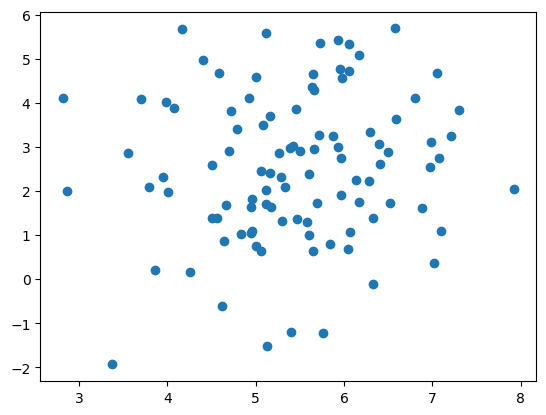

In [4]:
np.random.seed(100)
G = Random2DGaussian()
X = G.get_sample()
plt.scatter(X[:, 0], X[:, 1])
plt.show()

## 2. Učenje binarne logističke regresija gradijentnim spustom

### 2.1 Funkcija za treniranje modela binarne logističke regresije

In [61]:
def binlogref_train(
        X: ndarray,
        Y_: ndarray,
        param_niter: int = 1,
        param_delta: float = 0.1
) -> Tuple[ndarray, float]:
    """
    Training parameters w and b for logistic regression model.
    
    :param X: data matrix 
    :param Y_: correct labels
    :param param_niter: number of iterations
    :param param_delta: step size
    :return: trained parameters w and b
    """

    w: ndarray = np.random.randn(X.shape[1])
    b: float = 0
    N: int = X.shape[0]
    print(w)
    for i in range(param_niter):
        scores: ndarray = np.dot(X, w) + b
        print("Scores")
        print(scores.shape)
        probs: ndarray = 1 / (1 + np.exp(-scores))
        ## print(f"Probability: {probs}")
        error = 0

        for j in range(len(Y_)):
            error += -Y_[j] * np.log(probs[j]) - (1 - Y_[j]) * np.log(1 - probs[j])
        error = error / N
        
        # loss: float = -np.sum(np.log(pred)) / N
        if i % 10 == 0:
          #  print(f'Iteration: {i}, Loss: {loss}')
            print(f'Iteration: {i}, Error: {error}')
            # print(f'\tWeights: {w}, bias: {b}')

        dL_dscores = probs - np.squeeze(Y_)

        grad_w: ndarray = np.dot(X.T, dL_dscores) / N
        grad_b: float = np.sum(dL_dscores) / N

        w += -param_delta * grad_w
        b += -param_delta * grad_b

    return w, b

### 2.2 Funkcija za klasifikaciju primjera

In [35]:
def binlogreg_classification(X: ndarray, w: ndarray, b: float) -> ndarray:
    """
    Binary logistic regression classifier with weights w and bias b.
    :param X: data
    :param w: weights
    :param b: bias
    :return: probability of data to be in class c1
    """

    if X.shape[1] != w.shape[0]:
        raise ValueError('Invalid shape for weights. Weights shape : {} and data shape : {}'.format(w.shape, X.shape))
    if b is None:
        raise ValueError('Bias is not defined')

    scores: ndarray = np.dot(X, w) + b
    return 1 / (1 + np.exp(-scores))

### 2.3 Sample gauss function
Generating C random bivariant Gauss distributions.

In [36]:
def sample_gauss_2d(C: int, N: int) -> Tuple[ndarray, np.ndarray]:
    G = Random2DGaussian()
    X = G.get_sample(size=N)
    Y = np.array([[0]] * N)

    for i in range(1, C):
        G = Random2DGaussian()
        X = np.vstack((X, G.get_sample(N)))
        Y = np.vstack((Y, [[i]] * N))

    return X, Y


In [37]:
sample_gauss_2d(2, 10)

(array([[8.05330757, 6.5945604 ],
        [7.96299763, 5.88522714],
        [6.72814924, 6.40000658],
        [8.15121021, 5.94263465],
        [7.99467512, 5.90516106],
        [8.83138026, 6.12135531],
        [8.92098227, 4.16164142],
        [8.51556124, 6.05407974],
        [8.75310008, 6.1303006 ],
        [9.91437873, 4.75966956],
        [6.32031383, 6.22787495],
        [5.73898095, 3.31978684],
        [7.00531028, 7.20857919],
        [7.07494599, 5.40737086],
        [5.11516428, 3.09378665],
        [5.17722605, 4.21852132],
        [5.92225164, 4.93603226],
        [6.76154481, 7.39792146],
        [5.60915582, 5.49032835],
        [4.67832456, 3.81796642]]),
 array([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]]))

### 2.3 Statistical accuracy

#### 2.3.1 Get statistical data
Function for calculating TP, TN, FN, FP

In [38]:
def get_statistical_data(Y_: ndarray, Y: ndarray) -> Tuple[float, float, float, float]:
    """
    Calculating TP, TN, FP, FN
    :param Y_: Correct classes
    :param Y: Predicted classes
    :return: TP, TN, FN, FP
    """

    TP = np.sum(np.logical_and(Y_ == Y, Y_ == 1))
    TN = np.sum(np.logical_and(Y_ == Y, Y_ == 0))
    FP = np.sum(np.logical_and(Y_ != Y, Y == 1))
    FN = np.sum(np.logical_and(Y_ != Y, Y == 0))

    return TP, TN, FP, FN

In [39]:
get_statistical_data(
    np.array([1, 0, 0, 1, 1]), np.array([1, 0, 1, 0, 1])
)

(2, 1, 1, 1)

#### 2.3.2 Function eval_perf_binary

In [40]:
def eval_perf_binary(Y: ndarray, Y_: ndarray) -> Tuple[float, float, float]:
    """
    Calculating accuracy, precision and recall
    :param Y_: Correct classes
    :param Y: Predicted classes
    :return: accuracy, precision and recall
    """

    if len(Y) != len(Y_):
        raise ValueError("Predicted classes must have the same length as actual classes")

    TP, TN, FP, FN = get_statistical_data(Y_=Y_, Y=Y)

    print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

    accuracy = (TP + TN) / (TP + TN + FN + FP)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    return accuracy, precision, recall

#### 2.3.3 Function eval_AP

In [41]:
### TODO

### 2.4 Test code

In [58]:
np.random.seed(100)

X, Y_ = sample_gauss_2d(2, 100)
w, b = binlogref_train(X, Y_, param_niter=1, param_delta=0.2)
probs = binlogreg_classification(X, w, b)
Y = np.round(probs).astype(int)
Y_ = np.squeeze(Y_)
accuracy, precision, recall = eval_perf_binary(Y_, Y)
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

[ 1.48789443 -0.35781685]
Scores
(200,)
Y_:
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 

In [60]:
X

array([[ 4.78471104,  3.40245653],
       [ 5.59893671,  2.38687115],
       [ 5.63332248,  4.35957547],
       [ 4.95248799,  1.82240276],
       [ 5.15549963,  2.410959  ],
       [ 5.08282039,  3.50910007],
       [ 4.00125705,  1.97865106],
       [ 4.95183935,  1.09489227],
       [ 4.91784346,  4.11994966],
       [ 5.26475241,  2.85830851],
       [ 5.58471899,  1.30729401],
       [ 5.32541462,  2.09720781],
       [ 5.93435063,  5.41785058],
       [ 7.05230344,  4.68946487],
       [ 5.72737617,  5.37082561],
       [ 4.55758137,  1.38281333],
       [ 6.13032153,  2.24564803],
       [ 6.32631735, -0.10080164],
       [ 4.94883341,  1.05820135],
       [ 5.40374791, -1.20496135],
       [ 6.57507436,  5.68896838],
       [ 5.93103336,  2.99277088],
       [ 4.25797174,  0.15482832],
       [ 4.65926139,  1.69121339],
       [ 4.94507052,  1.63265199],
       [ 6.0598389 ,  5.34782571],
       [ 5.17521231,  1.64647167],
       [ 2.81444144,  4.12252665],
       [ 4.69427726,

In [51]:
Y_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

## 3. Grafički prikaz rezultata klasifikacije

In [13]:
def graph_data(X: ndarray, Y_: ndarray, Y: ndarray, special: list = []) -> None:
    """
    :param special: for special points
    :param X: data 
    :param Y_: correct labels
    :param Y: predicted labels
    :return: None
    """
    # colors of the datapoint markers
    palette = ([0.5, 0.5, 0.5], [1, 1, 1], [0.2, 0.2, 0.2])
    colors = np.tile([0.0, 0.0, 0.0], (Y_.shape[0], 1))
    for i in range(len(palette)):
        colors[Y_ == i] = palette[i]

    # sizes of the datapoint markers
    sizes = np.repeat(20, len(Y_))
    sizes[special] = 40

    # draw the correctly classified datapoints
    good = (Y_ == Y)
    plt.scatter(X[good, 0], X[good, 1], c=colors[good], s=sizes[good], marker='o', edgecolors='black')

    # draw the incorrectly classified datapoints
    bad = (Y_ != Y)
    plt.scatter(X[bad, 0], X[bad, 1], c=colors[bad], s=sizes[bad], marker='s', edgecolors='black')

In [14]:
 def myDummyDecision(X):
    scores = X[:, 0] + X[:, 1] - 5
    return scores

Iteration: 0, Error: [3.59841584]
Iteration: 10, Error: [0.71872829]
Iteration: 20, Error: [0.18721056]
Iteration: 30, Error: [0.15433528]
Iteration: 40, Error: [0.13923673]
Iteration: 50, Error: [0.12925521]
Iteration: 60, Error: [0.12202598]
Iteration: 70, Error: [0.11647246]
Iteration: 80, Error: [0.11202682]
Iteration: 90, Error: [0.10835803]


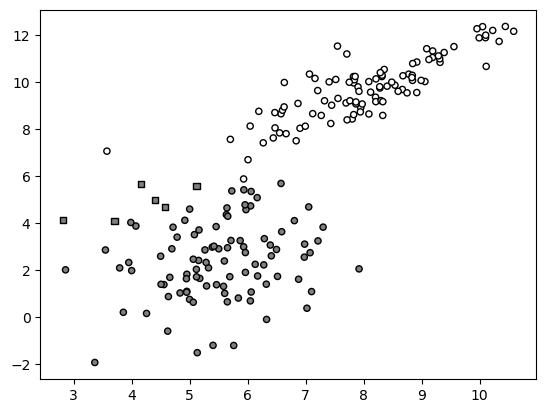

In [15]:
np.random.seed(100)
X, Y_ = sample_gauss_2d(2, 100)
w, b = binlogref_train(X, Y_, param_niter=100, param_delta=0.2)
probs = binlogreg_classification(X, w, b)
Y = np.round(probs).astype(int)
Y_ = np.squeeze(Y_)
graph_data(X, Y_, Y)
plt.show()

## 4. Iscrtavanje funkcije odluke

In [16]:
def graph_surface(function, rect, offset=0.5, width=256, height=256):
    """Creates a surface plot (visualize with plt.show)
  
    Arguments:
      function: surface to be plotted
      rect:     function domain provided as:
                ([x_min,y_min], [x_max,y_max])
      offset:   the level plotted as a contour plot
  
    Returns:
      None
    """

    lsw = np.linspace(rect[0][1], rect[1][1], width)
    lsh = np.linspace(rect[0][0], rect[1][0], height)
    xx0, xx1 = np.meshgrid(lsh, lsw)
    grid = np.stack((xx0.flatten(), xx1.flatten()), axis=1)

    #get the values and reshape them
    values = function(grid).reshape((width, height))

    # fix the range and offset
    delta = offset if offset else 0
    maxval = max(np.max(values) - delta, - (np.min(values) - delta))

    # draw the surface and the offset
    plt.pcolormesh(xx0, xx1, values,
                   vmin=delta - maxval, vmax=delta + maxval)

    if offset != None:
        plt.contour(xx0, xx1, values, colors='black', levels=[offset])

Iteration: 0, Error: [3.59841584]
Iteration: 10, Error: [0.71872829]
Iteration: 20, Error: [0.18721056]
Iteration: 30, Error: [0.15433528]
Iteration: 40, Error: [0.13923673]
Iteration: 50, Error: [0.12925521]
Iteration: 60, Error: [0.12202598]
Iteration: 70, Error: [0.11647246]
Iteration: 80, Error: [0.11202682]
Iteration: 90, Error: [0.10835803]


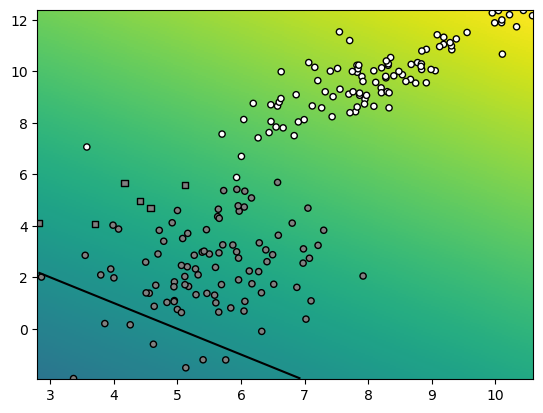

In [17]:
np.random.seed(100)

# get the training dataset
X, Y_ = sample_gauss_2d(2, 100)

# get the class predictions
w, b = binlogref_train(X, Y_, param_niter=100, param_delta=0.2)
probs = binlogreg_classification(X, w, b)
Y = np.round(probs).astype(int)
Y_ = np.squeeze(Y_)

# graph the surface
bbox = (np.min(X, axis=0), np.max(X, axis=0))
graph_surface(myDummyDecision, bbox, offset=0)

# graph the data points
graph_data(X, Y_, Y)

# show the results
plt.show()

## 5. Grafički prikaz binarne logističke regresije

In [18]:
def binlogreg_decfun(w, b):
    def classify(X):
        return binlogreg_classification(X, w, b)

    return classify

Iteration: 0, Error: [3.59841584]
Iteration: 10, Error: [0.71872829]
Iteration: 20, Error: [0.18721056]
Iteration: 30, Error: [0.15433528]
Iteration: 40, Error: [0.13923673]
Iteration: 50, Error: [0.12925521]
Iteration: 60, Error: [0.12202598]
Iteration: 70, Error: [0.11647246]
Iteration: 80, Error: [0.11202682]
Iteration: 90, Error: [0.10835803]
TP: 100, TN: 94, FP: 6, FN: 0
0.97 0.9433962264150944 1.0


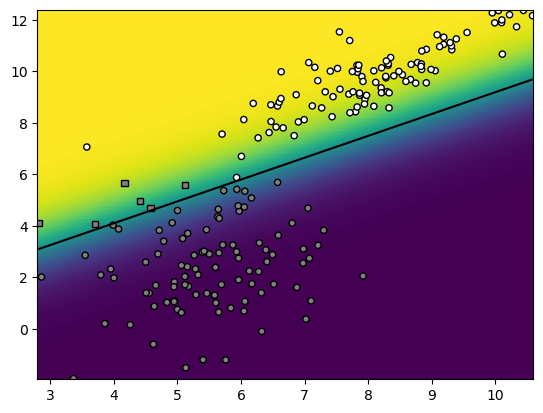

In [19]:
np.random.seed(100)

# instantiate the dataset
X, Y_ = sample_gauss_2d(2, 100)

# train the logistic regression model
w, b = binlogref_train(X, Y_, param_niter=100, param_delta=0.2)
probs = binlogreg_classification(X, w, b)
Y = np.round(probs).astype(int)
Y_ = np.squeeze(Y_)

# evaluate and print performance measures
acc, recall, precision = eval_perf_binary(Y, Y_)
#AP = eval_AP(Y_[probs.flatten().argsort()])
print(acc, recall, precision)

# graph the decision surface
decfun = binlogreg_decfun(w, b)
bbox = (np.min(X, axis=0), np.max(X, axis=0))
graph_surface(decfun, bbox, offset=0.5)

# graph the data points
graph_data(X, Y_, Y)

# show the plot
plt.show()

## 6. Višerazredna logistička regresija

In [70]:
def calculate_loss(probs: ndarray, Y_: ndarray) -> float:
    """
    Calculates the loss of multinomial logistic regression
    :param probs: calculated probabilities
    :param Y_: True labels for multinomial logistic
    :return: loss
    """
    correct_probs = probs[np.arange(len(Y_)), Y_]
    loss = -np.mean(np.log(correct_probs))
    return loss


In [71]:
from tensorflow.keras.utils import to_categorical


def logreg_train(
        X: ndarray,
        Y_: ndarray,
        num_iterations: int = 100,
        learning_rate: float = 0.1,
        print_constant: int = 1000
) -> Tuple[ndarray, ndarray]:
    """
    
    :param X: data 
    :param Y_: true labels
    :return: 
    """

    num_of_classes: int = max(Y_)[0] + 1
    num_of_features: int = X.shape[1]

    ##print(f"Number of classes: {num_of_classes}")
    ##print(f"Number of features: {num_of_features}")

    w: ndarray = np.random.randn(num_of_classes, num_of_features)
    b: ndarray = np.zeros(num_of_classes)
    N: int = X.shape[0]
    expended_y = to_categorical(Y_, num_classes=num_of_classes)

    # print(w)
    # print(b)
    # print(f"Shape of w: {w.shape}")
    # print(f"Shape of b: {b.shape}")
    # print(f"Shape of X: {X.shape}")
    # print(f"Shape of Y: {Y_.shape}")
    # print(f"Learning rate: {learning_rate}")
    # print(f"Expended y: \n{expended_y}")

    for i in range(num_iterations):
        scores: ndarray = np.dot(X, np.transpose(w)) + b
        ## print(f"Scores: \n {scores}")
        ## print(f"Shape of scores: {scores.shape}")
        exp_scores: ndarray = np.exp(scores)
        ## print(f"Exp scores: \n {exp_scores}")
        ## print(f"Shape of exp_scores: {exp_scores.shape}")

        sum_exp: ndarray = np.sum(exp_scores, axis=1, keepdims=True)
        ## print(f"Sum of exp scores: {sum_exp}")
        ## print(f"Shape of sum exp scores: {sum_exp.shape}")

        probs: ndarray = exp_scores / sum_exp
        ## print(f"Probabilities: {probs}")
        ## print(f"Shape of probs: {probs.shape}")
        ## print(f"Sum of probabilities: {np.sum(probs, axis=1, keepdims=True)}")

        loss: float = calculate_loss(probs, Y_)
        if i % print_constant == 0:
            # print(f"w: \n{w}")
            # print(f"b: \n{b}")
            # print(f"scores: \n{scores}""")
            print("iteration {}: loss {}".format(i, loss))

        dL_ds = probs - expended_y
        grad_W = (np.dot(np.transpose(dL_ds), X)) / N  #...  # C x D (ili D x C)
        ## print(f"grad_W: {grad_W}")
        ## print(f"grad_W shape: {grad_W.shape}")
        grad_b = (np.sum(np.transpose(dL_ds), axis=1)) / N  #...  # C x 1 (ili 1 x C)

        w += -learning_rate * grad_W
        b += -learning_rate * grad_b

    return w, b

In [72]:
X, Y_ = sample_gauss_2d(2, 10)
logreg_train(X, Y_, 10000, 0.01, print_constant=1000)

iteration 0: loss 5.087208179744172
iteration 1000: loss 0.707923831226247
iteration 2000: loss 0.7151604794796582
iteration 3000: loss 0.7171278380826551
iteration 4000: loss 0.718573011368542
iteration 5000: loss 0.7202398039631415
iteration 6000: loss 0.7222013522720668
iteration 7000: loss 0.7244349393419524
iteration 8000: loss 0.7269074086930655
iteration 9000: loss 0.729587305170758


(array([[-0.70484606, -0.27089834],
        [-0.70482918,  0.58460151]]),
 array([ 2.03439807, -2.03439807]))

In [65]:
def logreg_classify(X: ndarray, w: ndarray, b: ndarray) -> ndarray:
    scores: ndarray = np.dot(X, np.transpose(w)) + b
    exp_scores: ndarray = np.exp(scores)
    sum_exp: ndarray = np.sum(exp_scores, axis=1, keepdims=True)
    return exp_scores / sum_exp

In [66]:
X, Y_ = sample_gauss_2d(2, 100)
np.unique(Y_), len(np.unique(Y_))

(array([0, 1]), 2)

iteration 0: loss 2.4544373864702074
iteration 1000: loss 0.7569626593134439
iteration 2000: loss 0.75131392531937
iteration 3000: loss 0.7517252718918933
iteration 4000: loss 0.7530878775783327
iteration 5000: loss 0.7548231069509351
iteration 6000: loss 0.7568437816427566
iteration 7000: loss 0.7591179261978183
iteration 8000: loss 0.7616210906790531
iteration 9000: loss 0.7643310794053093
iteration 10000: loss 0.7672273321735446
iteration 11000: loss 0.7702908086115423
iteration 12000: loss 0.7735039188219204
iteration 13000: loss 0.7768504522695248
iteration 14000: loss 0.7803155020904597
iteration 15000: loss 0.7838853866335327
iteration 16000: loss 0.7875475701428876
iteration 17000: loss 0.7912905841244243
iteration 18000: loss 0.7951039505731418
iteration 19000: loss 0.7989781079252744


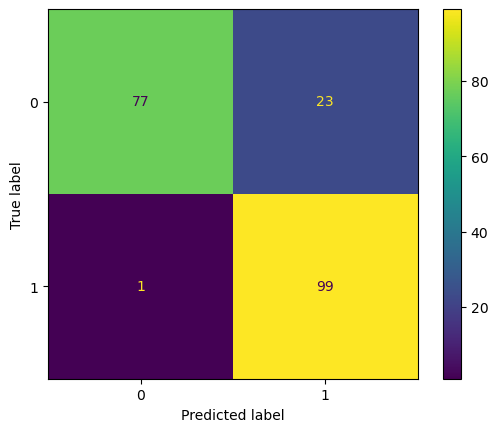

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X, Y_ = sample_gauss_2d(2, 100)
w, b = logreg_train(X, Y_, 20000, 0.01)
probs = logreg_classify(X, w, b)
Y = np.argmax(probs, axis=1)
classes = np.unique(Y_)
cm = confusion_matrix(Y_, Y, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(Y_, Y)
precision = precision_score(Y_, Y, average='macro')
recall = recall_score(Y_, Y, average='macro')
f1 = f1_score(Y_, Y, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.995
Precision: 0.995049504950495
Recall: 0.995
F1 Score: 0.9949998749968749


Number of classes: 3
Number of features: 2
[[-0.14070209 -0.00444355]
 [-0.51211756  1.33687363]
 [-0.19311018 -0.35176538]]
[0. 0. 0.]
Shape of w: (3, 2)
Shape of b: (3,)
Shape of X: (300, 2)
Shape of Y: (300, 1)
Learning rate: 0.01
Expended y: 
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0

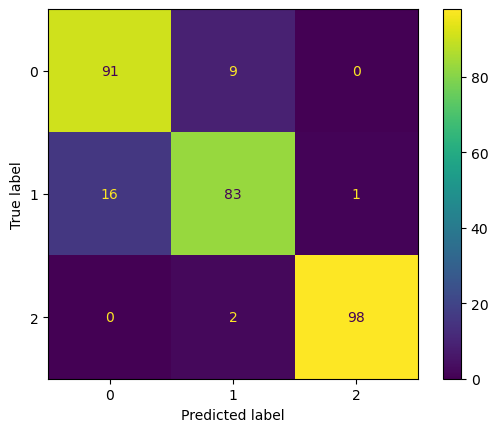

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X, Y_ = sample_gauss_2d(3, 100)
w, b = logreg_train(X, Y_, 20000, 0.01)
probs = logreg_classify(X, w, b)
Y = np.argmax(probs, axis=1)
classes = np.unique(Y_)
cm = confusion_matrix(Y_, Y, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(Y_, Y)
precision = precision_score(Y_, Y, average='macro')
recall = recall_score(Y_, Y, average='macro')
f1 = f1_score(Y_, Y, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9066666666666666
Precision: 0.9077816676742905
Recall: 0.9066666666666666
F1 Score: 0.9066072597828193
